## Project Description

In this project, a supermarket franchise wants to determine whether Data Science can help them in legal matters by ensuring that they do not sell age-restricted products to underage customers. Keeping in mind the following:

- The franchise stores are equipped with cameras at the checkout area that will trigger a signal when someone purchases age-restricted products.
- Computer vision methods can be used to determine a person's age from a photo.
- Your task is to build and evaluate a model to verify a person's age.

## Content

* [Project Description]
* [Step 1 Initialization]
* [Step 2 Import Data]
* [Step 3 EDA]
    * [Step 3.1 Finding]
* [Step 4 Modelling]
* [Step 5 Script to Run The Code in GPU Platform]
    * [Step 5.1 Output]
* [Step 6 Conclusion]

## Initialization 

In [1]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Import Data

The dataset you need is stored in the folder `/datasets/faces/`. In this folder, you can find:

- The `final_file` folder with 7.6 thousand photos.
- The `labels.csv` file that contains labels with two columns: `file_name` and `real_age`.

Considering the significant number of image files, it is advisable not to read them all at once, as it can consume a lot of computational resources. We recommend creating a generator with ImageDataGenerator. This method has been explained in Chapter 3, Lesson 7.

The label file can be loaded as a regular CSV file.

In [2]:
label = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(
dataframe=label,
directory='/datasets/faces/final_files/',
x_col='file_name',
y_col='real_age',
target_size=(224, 224),
batch_size=32,
class_mode='raw',
seed=1234)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_datagen_flow)

In [4]:
features.shape

(32, 224, 224, 3)

In [5]:
target

array([ 2, 28, 28, 55, 32, 36, 38, 65, 10, 32, 27, 21, 23, 15, 35, 67,  1,
       32, 19, 25,  5, 49, 24, 24, 27, 76, 10,  3, 22, 26, 19, 22])

## EDA

In [6]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
label.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [8]:
label.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<AxesSubplot:>

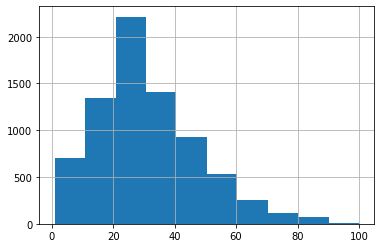

In [9]:
label['real_age'].hist()

In [10]:
count_age = label['real_age'].value_counts().reset_index()
count_age.rename(columns={'index':'age', 'real_age':'counts'}, inplace=True)

In [11]:
count_age.head()

,age,counts
0,30,317
1,25,315
2,27,229
3,26,226
4,28,217


<AxesSubplot:xlabel='age', ylabel='counts'>

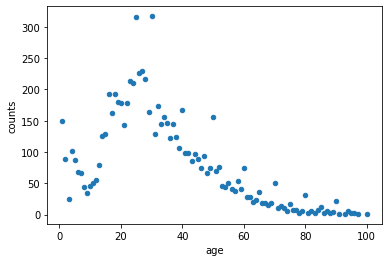

In [12]:
count_age.plot(kind='scatter', x='age', y='counts')

<AxesSubplot:>

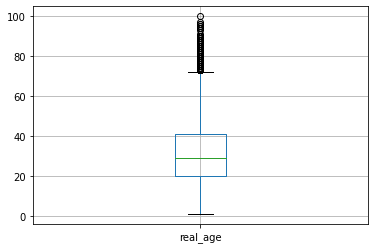

In [13]:
label.boxplot(column=['real_age'])

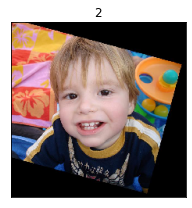

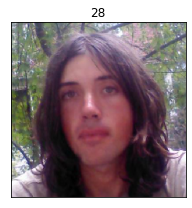

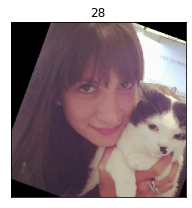

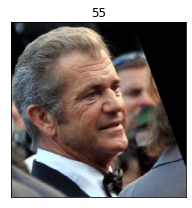

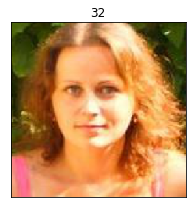

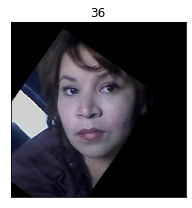

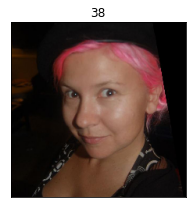

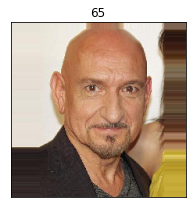

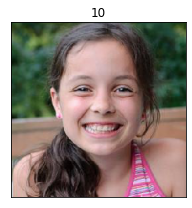

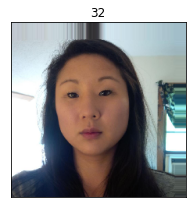

In [14]:
import matplotlib.pyplot as plt

for pic, age in zip(features[:10], target[:10]):
    plt.figure(figsize=(3,3))
    plt.title(age)
    plt.imshow(pic)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Finding

Based on the Exploratory Data Analysis (EDA) results, it was found that the most visited age group at the store consists of people who are nearly 30 years old.

In the data description, it shows that the median age is 29, the mean age is 31, and the age group that shops the most is between the 20s and 30s. The histogram diagram also indicates that our data is skewed to the left or left-skewed. Therefore, the model might face some challenges in predicting the age of the oldest customers.

The displayed images cover people aged from 4 to 73 years. The images vary in terms of orientation, with some tilted and others stretched sideways. This diversity in image data is highly beneficial for the model training process as it exposes the model to a wide range of image variations.

## Modelling

In [27]:
def load_train(path):
    
    """
    This code is to load a part of training set from file path
    """
    
    label = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                rescale=1/255,
                                horizontal_flip=True,
                                vertical_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=label,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345)

    return train_gen_flow

In [28]:
def load_test(path):
    
    """
    This code is to load a part of validation set/test from file path
    """
    
    # letakkan kode Anda di sini
    label = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                rescale=1/255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=label,
                                               directory=path + 'final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=12345)

    return test_gen_flow

In [29]:
def create_model(input_shape):
    
    """
    This code is to define a model
    """
    
    # letakkan kode Anda di sini
    model=Sequential()
    optimizer=Adam(lr=0.0001)
    backbone = ResNet50(include_top=False,
                        input_shape=input_shape,
                        weights='imagenet')
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model

In [30]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Train the model with the given paramter
    """
    
    # letakkan kode Anda di sini
    if steps_per_epoch is None:
        steps_per_epoch == len(train_data)
    if validation_steps is None:
        validation_steps == len(test_data)
    model.fit(train_data,
             validation_data=test_data,
             batch_size=batch_size,
             epochs=epochs,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             verbose=2,
             shuffle=True)

    return model

## Siapkan Skrip untuk menjalankan platform GPU

Setelah Anda mendefinisikan fungsi-fungsi yang diperlukan, Anda dapat membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip Anda juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [31]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Letakkan *output* dari platform GPU sebagai sel *Markdown* di sini.

Train for 178 steps, validate for 60 steps

Epoch 1/10
2023-07-21 09:21:21.338651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-21 09:21:22.641319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 260.8599 - mae: 11.8112 - val_loss: 854.6676 - val_mae: 24.3584

Epoch 2/10
178/178 - 37s - loss: 108.5599 - mae: 7.8543 - val_loss: 787.5877 - val_mae: 23.1360

Epoch 3/10
178/178 - 37s - loss: 79.8954 - mae: 6.7540 - val_loss: 331.5659 - val_mae: 13.6182

Epoch 4/10
178/178 - 38s - loss: 64.5847 - mae: 6.0936 - val_loss: 177.1926 - val_mae: 10.2981

Epoch 5/10
178/178 - 38s - loss: 55.3782 - mae: 5.6527 - val_loss: 156.2710 - val_mae: 9.7947

Epoch 6/10
178/178 - 38s - loss: 46.9172 - mae: 5.2246 - val_loss: 130.0500 - val_mae: 8.3887

Epoch 7/10
178/178 - 38s - loss: 38.4722 - mae: 4.7398 - val_loss: 85.9003 - val_mae: 7.0769

Epoch 8/10
178/178 - 37s - loss: 34.6126 - mae: 4.4681 - val_loss: 90.4974 - val_mae: 7.0490

Epoch 9/10
178/178 - 37s - loss: 29.9437 - mae: 4.1334 - val_loss: 72.3038 - val_mae: 6.4217

Epoch 10/10
178/178 - 37s - loss: 25.3841 - mae: 3.8546 - val_loss: 69.5138 - val_mae: 6.1800
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

60/60 - 9s - loss: 69.5138 - mae: 6.1800
Test MAE: 6.1800

## Kesimpulan

**Kesimpulan EDA:**
- Pada bagian EDA, terlihat bahwa orang yang sering berbelanja adalah pengunjung usia paling banyak 20 sampai 40 tahun,
- Rata-rata pengunjung berusia 31 tahun dan sedikit pengunjung berumur lansia.

**Kesimpulan Model:**

Model yang kita akan buat adalah model jaringan saraf yang menggunakan arsitektur ResNet50. Dengan nilai epochs 10 dan jumlah neurol-nya adalah 1. Model memperoleh nilai MAE 6.18. Nilai yang kita harapkan yaitu di bawah 7. Meskipun nilai pada training set dan validation set sangat jauh, bisa jadi model kita mengalami overfitting. Namun, ini bukanlah masalah karena hal ini disebabkan oleh jumlah lapisan yang banyak.